In [1]:
### Importing required packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, OrderedDict
from pandas.plotting import table
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection as model
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [2]:
### Loading data
taxiData = pd.read_csv('C:\\Users\\nikhi\\PycharmProjects\\Challenge\\green_tripdata_2015-09.csv')

In [3]:
### 1. Data points
taxiData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

In [4]:
taxiData.shape

(1494926, 21)

## Part1. How Many Data Points in the dataset

In [5]:
print("Number of datapoints")
print(len(taxiData.index))

Number of datapoints
1494926


## Part 2. Histogram of the number of trip distance 

#### This Histogram represents the trip distance of all  1494926 trips where the x-axis is trip distance in miles and y-axis is number of trips with trip distance in log scale with base 2.

Text(0.5,1,'Trip distances for all the trips')

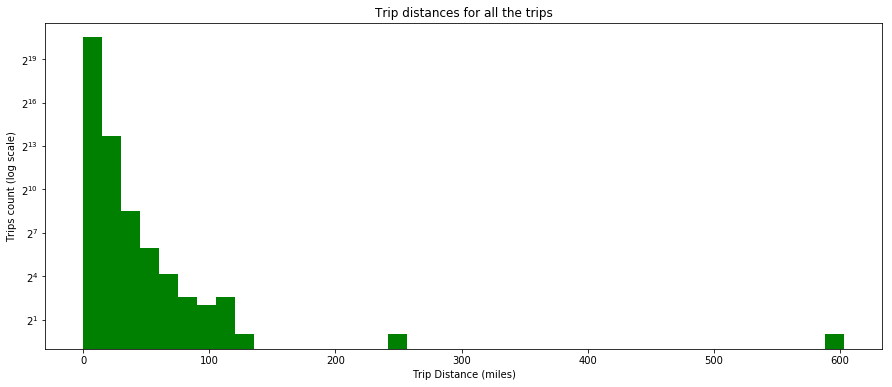

In [6]:
### Plotting the histogram of number of trip distance
plt.figure(figsize=(15,6))
plt.hist(taxiData.Trip_distance,bins=40,color='green')
plt.yscale('log' , basey=2)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trips count (log scale)')
plt.title('Trip distances for all the trips')

## Part 3. Finding mean and medain of trip distance daily based on each hour

In [7]:
## Converting the datatypes of objects to dates
taxiData.lpep_pickup_datetime = pd.to_datetime(taxiData.lpep_pickup_datetime)
taxiData.Lpep_dropoff_datetime = pd.to_datetime(taxiData.Lpep_dropoff_datetime)

##Creating attributes of date and hour from datetime variables
taxiData['pickupDate']  = taxiData.lpep_pickup_datetime.dt.date
taxiData['dropoffDate'] = taxiData.Lpep_dropoff_datetime.dt.date
taxiData['pickupHour']  = taxiData.lpep_pickup_datetime.dt.hour
taxiData['dropoffHour'] = taxiData.Lpep_dropoff_datetime.dt.hour

In [8]:
## grouping the data based on pickup date and pickup hour and finding their mean and median
groupedData = taxiData.groupby(['pickupDate','pickupHour']).agg({'Trip_distance' : ['mean','median']})
groupedDataDate = taxiData.groupby(['pickupDate']).agg({'Trip_distance' : ['mean','median']})
groupedDataHour = taxiData.groupby(['pickupHour']).agg({'Trip_distance' : ['mean','median']})

### The tabel represents the mean and median of trip distance grouped by an hour in a day

In [9]:
groupedData.head(30)

Trip_distance       
                               mean median
pickupDate pickupHour                     
2015-09-01 0               3.166337  2.020
           1               2.835592  1.920
           2               2.854331  1.860
           3               2.493597  1.640
           4               3.586338  2.080
           5               4.578571  3.220
           6               3.673889  2.600
           7               3.060544  2.195
           8               2.929748  2.095
           9               2.841745  1.870
           10              2.819880  1.800
           11              2.755064  1.730
           12              2.726632  1.720
           13              2.851565  1.800
           14              2.738829  1.730
           15              2.730195  1.780
           16              2.693676  1.700
           17              2.570443  1.655
           18              2.474204  1.630
           19              2.653772  1.730
           20              2.675839  1.820
           21              3.138004  2.100
           22              3.427804  2.250
           23              3.316807  2.200
2015-09-02 0               2.938096  2.000
           1               2.770812  1.945
           2               2.708379  1.700
           3               2.758673  1.730
           4               3.382725  2.100
           5               4.430632  3.335

### Bar Graph representing the mean and median of trip distance of every day in september 2015

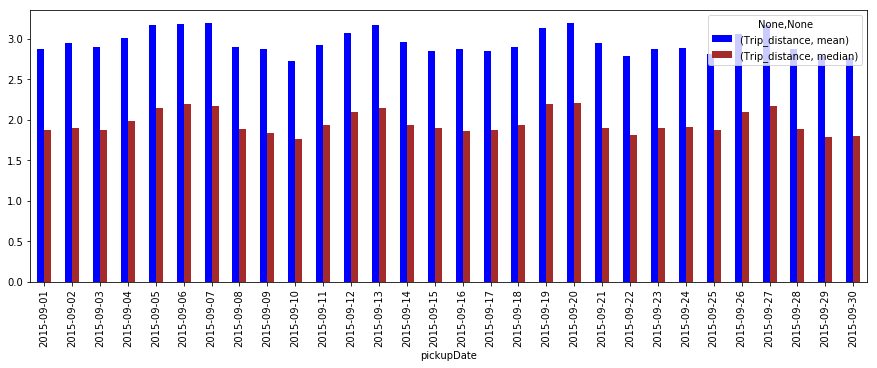

In [10]:
groupedDataDate.plot(kind='bar',figsize=(15,5),color=['blue','brown']);

### Heat Map representing the mean and median of trip distance based on pickup hour of all the days in september 2015 where the lighter color represents higher value and vice versa

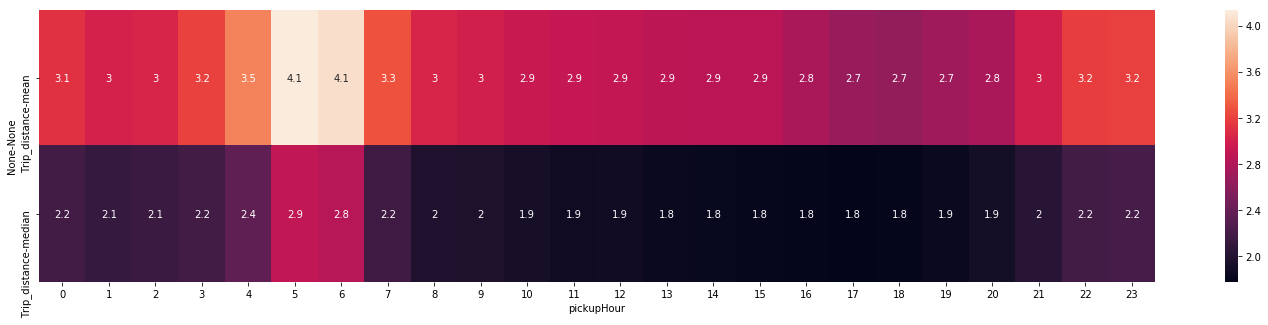

In [11]:
heatMap = groupedDataHour.transpose()
plt.figure(figsize=(25,5))
sns.heatmap(heatMap,annot=True);

## Part 4. Creating a model

#### Creating a suitable target variable
##### Since the objective is what kind of trips help drivers get more tip, we can check for different target variables which will be suitable as the target variable
1. Tips received
2. Tips greater than or equal to 5%
3. Tips greater than or equal to 10%
4. Tips greater than or equal to 20%

In [12]:
taxiData['tipGiven'] = np.where(taxiData['Tip_amount'] > 0,1,0)

### tip given is greater than or equal to 5% 
def tip5Percent(row):
    if (row['tipGiven'] > 0):
        if ((row['Tip_amount']/row['Total_amount']) >= 0.05):
            val = 1
        else:
            val = 0
    else:
        val = 0
    return val
taxiData['tipGiven5Percent'] = taxiData.apply(tip5Percent, axis=1)

### tip given is greater than or equal to 10%
def tip10Percent(row):
    if (row['tipGiven'] > 0):
        if ((row['Tip_amount']/row['Total_amount']) >= 0.1):
            val = 1
        else:
            val = 0
    else:
        val = 0
    return val
taxiData['tipGiven10Percent'] = taxiData.apply(tip10Percent, axis=1)

def tip20Percent(row):
    if (row['tipGiven'] > 0):
        if ((row['Tip_amount']/row['Total_amount']) >= 0.2):
            val = 1
        else:
            val = 0
    else:
        val = 0
    return val
taxiData['tipGiven20Percent'] = taxiData.apply(tip20Percent, axis=1)

### Proportions of the Percentage of the tip given (5%, 10%, 20%) compared to no tip

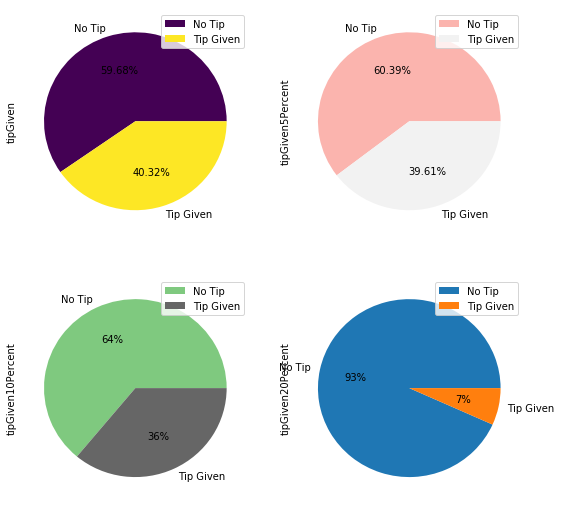

In [13]:
### Proporation of each category
#2 rows 2 cols
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(9,9))
taxiData.tipGiven.value_counts().plot(ax=axes[0,0],kind='pie',autopct='%1.2f%%',labels=['No Tip','Tip Given'],legend=True,colormap='viridis')
##
taxiData.tipGiven5Percent.value_counts().plot(ax=axes[0,1],kind='pie',autopct='%1.2f%%',labels=['No Tip','Tip Given'],legend=True,colormap='Pastel1')
##
taxiData.tipGiven10Percent.value_counts().plot(ax=axes[1,0],kind='pie',autopct='%1.0f%%',labels=['No Tip','Tip Given'],legend=True,colormap='Accent')
##
taxiData.tipGiven20Percent.value_counts().plot(ax=axes[1,1],kind='pie',autopct='%1.0f%%',labels=['No Tip','Tip Given'],legend=True);

From the above we can see that if tips were given it is mostly greater than 5% and nearly greater than 10% and only a very less fraction of people have given tips of greater than 20%. For further analysis, we will consider only tips that were greater than 5% and tips that were greater than 10% but less than 20%.

## processing the data and understanding how different variables affect the tip given percentage

### How RateCode Id affects the tip percentage

In [14]:
#### EDA
### Deleting the column Ehail_fee since there is no data in that and deleting tipGiven and tipGiven20Percent since those will
### not be used for further analysis
del taxiData['Ehail_fee']
del taxiData['Store_and_fwd_flag']

In [15]:
###Changing the type of variables where ever required:
taxiData = taxiData.astype({"Payment_type": str, "Trip_type ": str,"RateCodeID":str,"VendorID":str,"Passenger_count":str})

In [16]:
### Checking categorical variables
taxiData.RateCodeID.value_counts()

1     1454464
5       33943
2        4435
3        1117
4         925
6          36
99          6
Name: RateCodeID, dtype: int64

As we can see there are 6 trips with ratecode id as 99 which is not valid so replacing it with median.

### Bar Graph of the number of trips with tip percentage of 5% and 10% with respective to rate code id

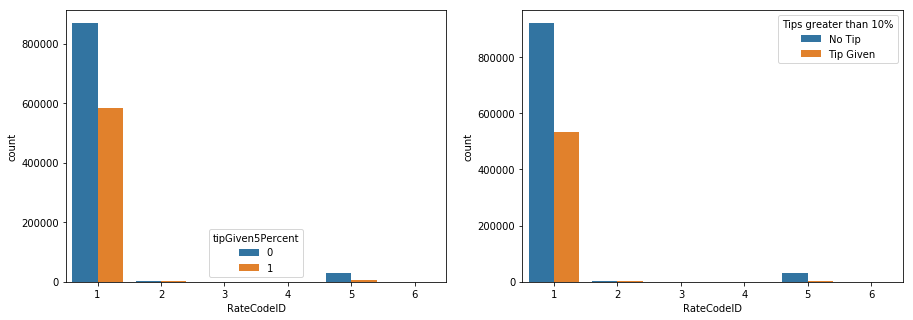

In [17]:
## 99 is not a valid ratecodeid, so replacing it with median.
taxiData['RateCodeID'] = taxiData.RateCodeID.replace(['99'], '1')
## Visualizing ratecode with target variable tips
fig, ax =plt.subplots(1,2,figsize=(15,5))
a = sns.countplot(x='RateCodeID',data=taxiData,hue='tipGiven5Percent',ax=ax[0])
b = sns.countplot(x='RateCodeID',data=taxiData,hue='tipGiven10Percent',ax=ax[1])
customlabels = ["No Tip", "Tip Given"]
plt.legend(title="Tips greater than 10%", loc='upper right', labels=customlabels)
plt.show()

Rate types:
1. Standard rate
2. JFK
3. Newark
4. Nassau or Westchester
5. Negotiated fare
6. Group ride

From the above graph we can see that there is not much of a difference in the tips, the amount of tip for type one (standard rate) is reducing when the tip amount is greater than 10%

### How Vendor Id affects the tip percentage

In [18]:
#The proporation of vendorID
taxiData.VendorID.value_counts()/len(taxiData)

2    0.782045
1    0.217955
Name: VendorID, dtype: float64

### Bar Graphs of the number of trips with tip percentage of 5% and 10% with respective to Vendor id

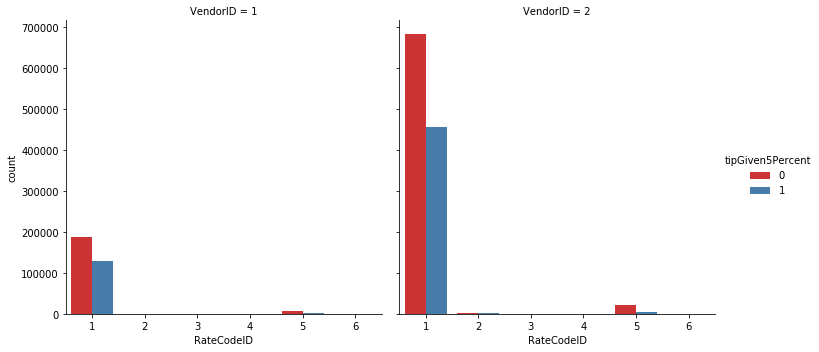

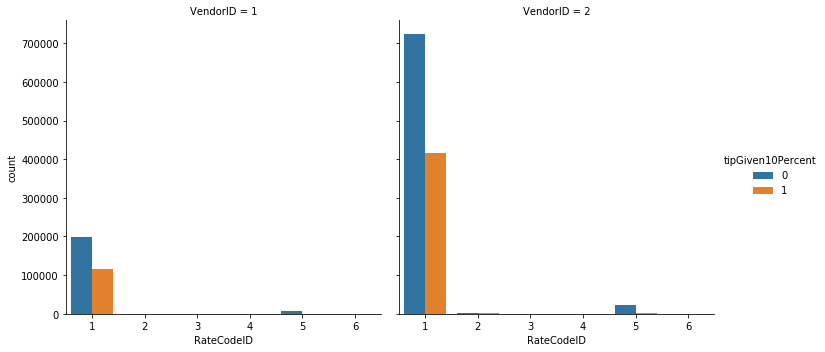

In [19]:
## VendorID
sns.catplot(x="RateCodeID",data=taxiData,kind="count",hue="tipGiven5Percent",col="VendorID",palette='Set1')
sns.catplot(x="RateCodeID",data=taxiData,kind="count",hue="tipGiven10Percent",col="VendorID");

From the graphs we can see that the proportion of tip is similar irrespective of the vendor. That should be the case in general

### How trip type affects the tip percentage

In [20]:
taxiData["Trip_type "].value_counts()
## Since only 4 values are missing, we are replacing it with mode.

1.0    1461506
2.0      33416
nan          4
Name: Trip_type , dtype: int64

In [21]:
##Checking trip_type
taxiData['Trip_type'] = taxiData['Trip_type ']
del taxiData['Trip_type ']

taxiData.Trip_type = taxiData.Trip_type.replace(['1.0'],'Stree Hail')
taxiData.Trip_type = taxiData.Trip_type.replace(['2.0'],'Dispatch')
taxiData.Trip_type = taxiData.Trip_type.replace(['nan'],'Stree Hail')
taxiData.Trip_type.value_counts()

Stree Hail    1461510
Dispatch        33416
Name: Trip_type, dtype: int64

### Bar Graphs of the number of trips with tip percentage of 5% and 10% with respective to Trip Type

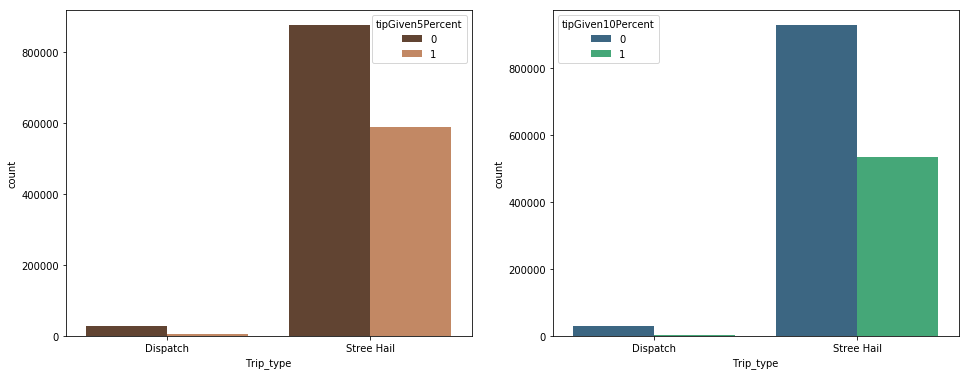

In [22]:
fig, ax =plt.subplots(1,2,figsize=(16,6))
a = sns.countplot(x='Trip_type',data=taxiData,hue='tipGiven5Percent',ax=ax[0],palette='copper')
b = sns.countplot(x='Trip_type',data=taxiData,hue='tipGiven10Percent',ax=ax[1],palette='viridis')

From the above graphs we can deduce that tips given for street hail is almost similar for 5% and 10%

### How payment type affects the tip percentage

Cash           783699
Credit Card    701287
No Charge        5498
Dispute          4368
Unknown            74
Name: Payment_type, dtype: int64


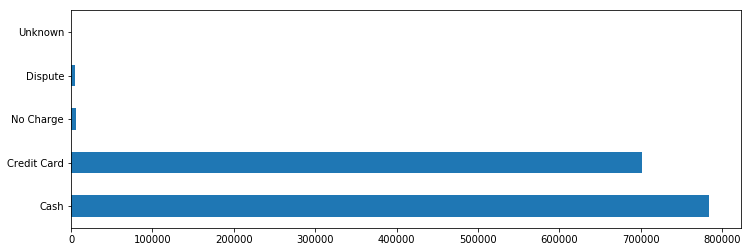

In [23]:
### Checking payment type
taxiData.Payment_type = taxiData.Payment_type
taxiData.Payment_type = taxiData.Payment_type.replace(['1'],'Credit Card')
taxiData.Payment_type = taxiData.Payment_type.replace(['2'],'Cash')
taxiData.Payment_type = taxiData.Payment_type.replace(['3'],'No Charge')
taxiData.Payment_type = taxiData.Payment_type.replace(['4'],'Dispute')
taxiData.Payment_type = taxiData.Payment_type.replace(['5'],'Unknown')
print(taxiData.Payment_type.value_counts())
taxiData.Payment_type.value_counts().plot(kind='barh',figsize=(12,4));

### Bar Graphs of the number of trips with tip percentage of 5% and 10% with respective to payment type

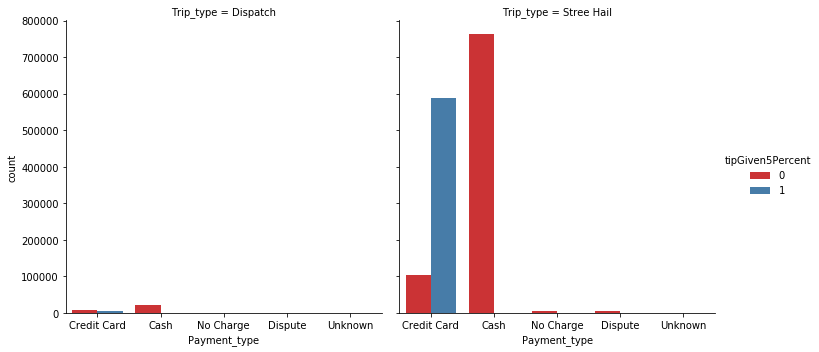

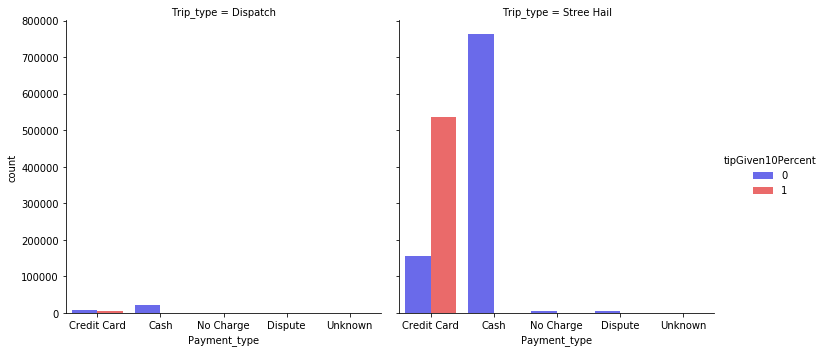

In [24]:
sns.catplot(x="Payment_type",data=taxiData,kind="count",hue="tipGiven5Percent",col="Trip_type",palette='Set1')
sns.catplot(x="Payment_type",data=taxiData,kind="count",hue="tipGiven10Percent",col="Trip_type",palette='seismic');

It makes sense, since the payment method is cash, the tip will also be given in cash if it is given. Also, it is mentioned in the dictionary, that the tip amount received by cash is not recorded. So for this specific model we can remove all the records which have done cash based transaction

### Final distribution of trips with tips given and not given with 5% and 10%

In [25]:
### Removing all the cash transaction records.
taxiDataFiltered_1 = taxiData[taxiData.Payment_type != 'Cash']

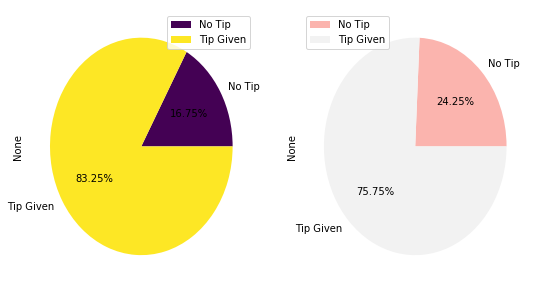

In [26]:
fig, axes = plt.subplots(ncols=2,figsize=(9,5))
taxiDataFiltered_1.groupby('tipGiven5Percent').size().plot(ax=axes[0],kind='pie',autopct='%1.2f%%',labels=['No Tip','Tip Given'],legend=True,colormap='viridis')
##
taxiDataFiltered_1.groupby('tipGiven10Percent').size().plot(ax=axes[1],kind='pie',autopct='%1.2f%%',labels=['No Tip','Tip Given'],legend=True,colormap='Pastel1');

With the filtered data 75.75% people have given at tip which is greater than 10% and more than 83% of the people have given a tip which is greater than 5%

### Bar Graph of the number of trips with tip percentage of 5% and 10% with respective to passenger count

In [27]:
taxiDataFiltered_1.Passenger_count.value_counts() 

1    599307
2     54030
5     26567
3     16146
6     10917
4      4056
0       168
8        23
7         8
9         5
Name: Passenger_count, dtype: int64

Most of rides are for single customers. There are 168 records with 0 customers, since the number is very less we are replacing that record with the mode.

C:\Users\nikhi\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


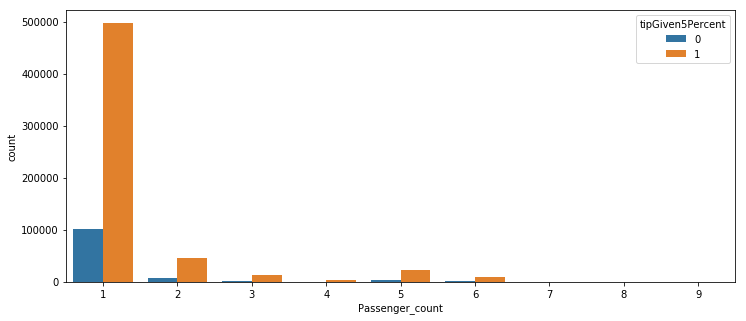

In [28]:
taxiDataFiltered_1.Passenger_count = taxiDataFiltered_1.Passenger_count.replace(['0'],'1')
plt.figure(figsize=(12,5))
sns.countplot(x="Passenger_count",hue="tipGiven5Percent",data=taxiDataFiltered_1);

There is no regular pattern there. However when there are more than 7 people then more proportion of people have not given tip.

### Number of trips after cleaning

In [29]:
taxiDataFiltered_1.shape

(711227, 27)

In [30]:
### Checking numerical variables
taxiDataNumericFields_1 = taxiDataFiltered_1[['Trip_distance','Fare_amount','Extra','MTA_tax','Tolls_amount','improvement_surcharge','Tip_amount']]

From the numerical variables I have removed total amount since it is the summation of all the charges during the trip and check how other variables perform. 

In [31]:
taxiDataNumericFields_1.describe()

Trip_distance    Fare_amount          Extra        MTA_tax  \
count  711227.000000  711227.000000  711227.000000  711227.000000   
mean        3.421753      14.049217       0.353985       0.488030   
std         3.287062      10.951549       0.364348       0.085114   
min         0.000000    -475.000000      -1.000000      -0.500000   
25%         1.270000       7.000000       0.000000       0.500000   
50%         2.400000      11.000000       0.500000       0.500000   
75%         4.420000      18.000000       0.500000       0.500000   
max       246.280000     500.000000       1.000000       0.500000   

        Tolls_amount  improvement_surcharge     Tip_amount  
count  711227.000000          711227.000000  711227.000000  
mean        0.176007               0.292992       2.597141  
std         1.072006               0.050644       2.976440  
min        -8.000000              -0.300000     -50.000000  
25%         0.000000               0.300000       1.080000  
50%         0.000000               0.300000       2.000000  
75%         0.000000               0.300000       3.350000  
max        95.750000               0.300000     300.000000

There is some discrepency in the data, the minimum tip amount is -50 and the minimum fare amount is -475 the negative values seem to be odd. There is a possibility that this is bad data or a credit card reversal due to some issue. 

In [32]:
analysis_data = taxiDataFiltered_1[(taxiDataFiltered_1.Fare_amount < 0) & (taxiDataFiltered_1.Tip_amount < 0) ].sort_values(by=['Fare_amount'],ascending=True)
analysis_data[['Fare_amount',"Payment_type","Tip_amount"]].head()

Fare_amount Payment_type  Tip_amount
402829         -56.0    No Charge      -11.20
1164904         -8.0      Dispute      -50.00
1293750         -5.0    No Charge       -0.63
1259283         -3.5    No Charge       -1.29
486631          -3.5  Credit Card       -0.96

Looking at some of them, makes us realize that, there might have been some dispute or some other reason that the fare amount or tip amount turned out to be negative. So, that data is not bad in this case. 

### plotting box plot to check for outliers.

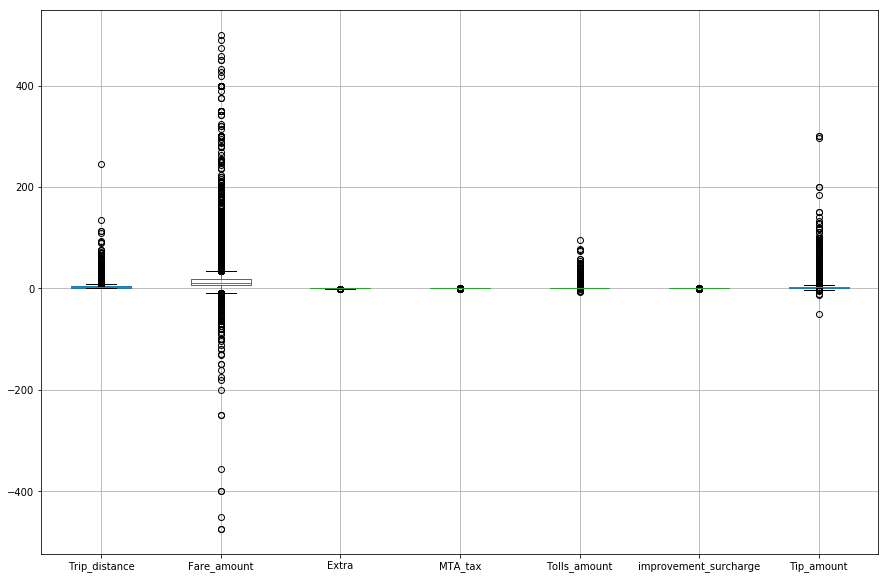

In [33]:
taxiDataNumericFields_1.boxplot(figsize=(15,10));

Following data points are considered to be outlier:
1. Trip_distance: Where trip distance is greater than 200 miles we have only one point which is an outlier.
2. Fare_amount: Greater than 400 dollars and less than -400 dollars there seems to be around 20 points 
3. Tip amount: Tip amount greater than 200, there seems to be 4 or 5 points 

We will remove these outliers from further analysis

In [34]:
taxiDataFiltered_2 = taxiDataFiltered_1[(taxiDataFiltered_1.Fare_amount < 400) & (taxiDataFiltered_1.Fare_amount > -400) & (taxiDataFiltered_1.Trip_distance < 200) & (taxiDataFiltered_1.Tip_amount < 200)]
taxiDataNumericFields_2 = taxiDataFiltered_2[['Trip_distance','Fare_amount','Extra','MTA_tax','Tolls_amount','improvement_surcharge','Tip_amount']]

### Histogram of number of trips against trip distance and fare amount 

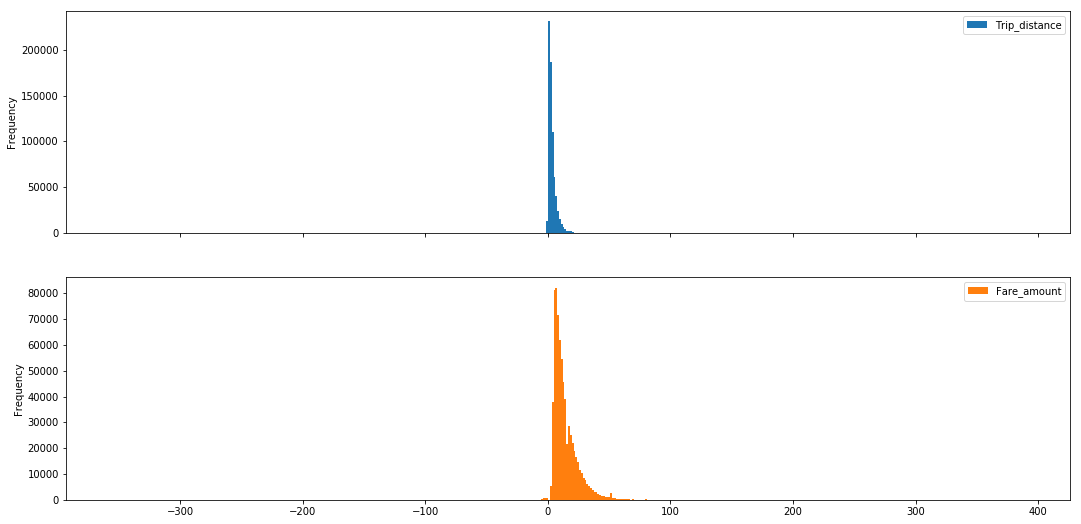

In [35]:
taxiDataNumericFields_2[['Trip_distance','Fare_amount']].plot.hist(subplots=True, legend=True,figsize=(18,9),bins=500);

Trip distance and fare amount distributions are almost similar, which makes sense. Trip distance should be directly proportional to fare amount. 

### Histogram of number of trips against tip amount and tolls amount

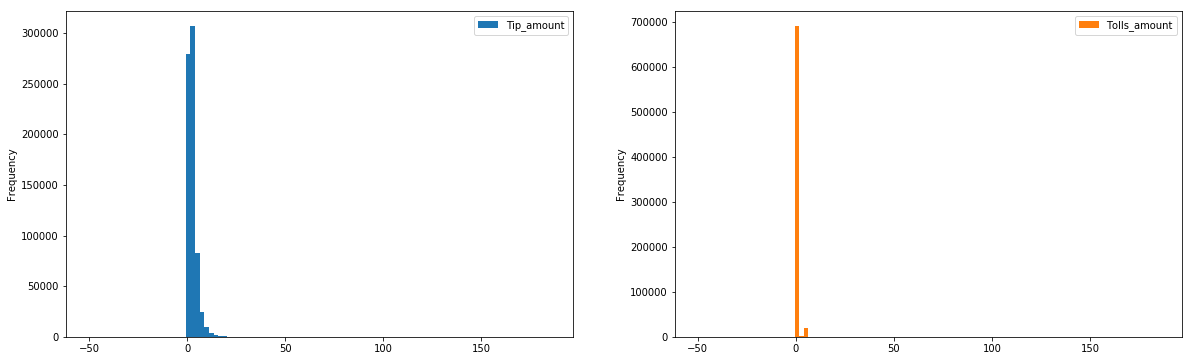

In [36]:
taxiDataNumericFields_2[['Tip_amount','Tolls_amount']].plot.hist(bins=100,subplots=True,layout=(1,2),figsize=(20,6));

Tip amount and tolls amount also seems to have the similar distribution.

### Histograms of number of trips against Extra amount, MTA_tax amount, Improvement surchage

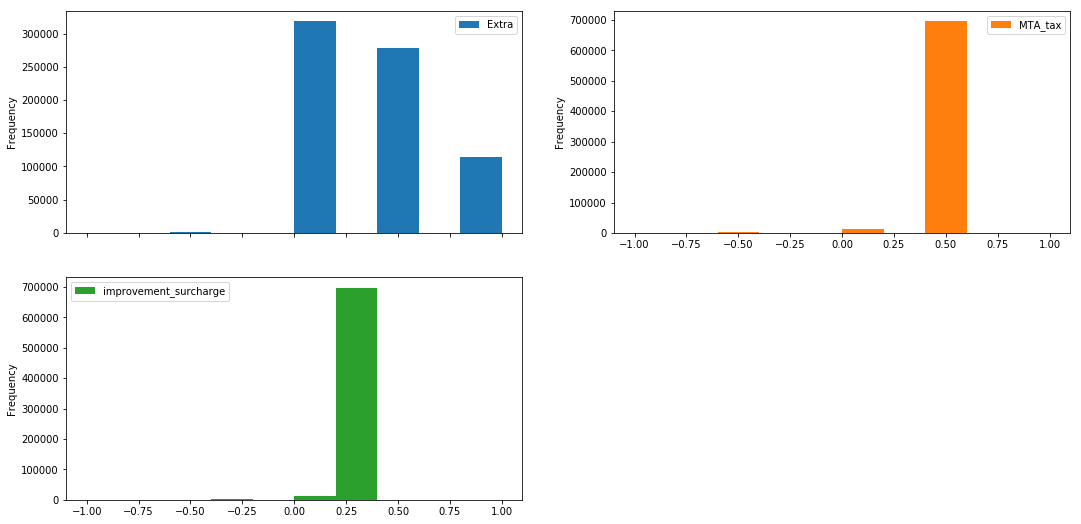

In [37]:
taxiDataNumericFields_2[['Extra','MTA_tax','improvement_surcharge']].plot.hist(subplots=True, legend=True,figsize=(18,9),layout=(2,2));

### Correlation amongst different variables

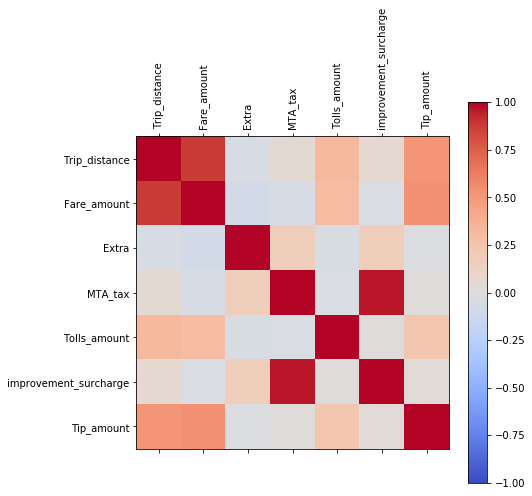

In [38]:
corr = taxiDataNumericFields_2.corr()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(taxiDataNumericFields_2.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(taxiDataNumericFields_2.columns)
ax.set_yticklabels(taxiDataNumericFields_2.columns)
plt.show()

Correlation can be found between:
1. Very High MTA_tax and improvement_surcharge
2. high correlation between fare_amount and trip distance
3. There is a correlation between tolls amount,trip distance and fare amount.

Point(1) We can use either one of the two variables, since they are highly correlated

Point(2) makes perfect sense, fare amount is linearly related to trip distance, so we can remove one of the two variable, for this analysis we will remove the fare_amount.

Point(3) makes sense, in the way, if the distance is large, there might be more tolls and the fare will increase based on the distance. We will keep the variable for this analysis. 

In [39]:
del taxiDataFiltered_2['Fare_amount']
del taxiDataFiltered_2['improvement_surcharge']

### Creating a date difference column

In [40]:
## date columns
### Creating a date difference column
taxiDataFiltered_2['trip_time_diff'] = (
    ((taxiDataFiltered_2['Lpep_dropoff_datetime']) - (taxiDataFiltered_2['lpep_pickup_datetime'])).dt.total_seconds() / 60)

C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [41]:
del taxiDataFiltered_2['lpep_pickup_datetime']
del taxiDataFiltered_2['Lpep_dropoff_datetime']

In [42]:
del taxiDataFiltered_2['tipGiven']
del taxiDataFiltered_2['tipGiven20Percent']

In [43]:
taxiDataFiltered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711193 entries, 0 to 1494925
Data columns (total 22 columns):
VendorID             711193 non-null object
RateCodeID           711193 non-null object
Pickup_longitude     711193 non-null float64
Pickup_latitude      711193 non-null float64
Dropoff_longitude    711193 non-null float64
Dropoff_latitude     711193 non-null float64
Passenger_count      711193 non-null object
Trip_distance        711193 non-null float64
Extra                711193 non-null float64
MTA_tax              711193 non-null float64
Tip_amount           711193 non-null float64
Tolls_amount         711193 non-null float64
Total_amount         711193 non-null float64
Payment_type         711193 non-null object
pickupDate           711193 non-null object
dropoffDate          711193 non-null object
pickupHour           711193 non-null int64
dropoffHour          711193 non-null int64
tipGiven5Percent     711193 non-null int64
tipGiven10Percent    711193 non-null int64
Tr

###  Creating direction variables

In [44]:
# creating direction variables and replacing pickup_latitude/dropoff_latitude with Direction_North_South 
# pickup_longitude/dropoff_longitude with Direction_East_West 

# if taxi is moving from north to south it is 2, south to north it is 1 and 0 otherwise
taxiDataFiltered_2['NS_Direction'] = (taxiDataFiltered_2.Pickup_latitude>taxiDataFiltered_2.Dropoff_latitude)*1+1
index = taxiDataFiltered_2[(taxiDataFiltered_2.Pickup_latitude == taxiDataFiltered_2.Dropoff_latitude) & (taxiDataFiltered_2.Pickup_latitude!=0)].index
taxiDataFiltered_2.loc[index,'NS_Direction'] = 0

# if taxi is moving from east to west it is 2, west to east it is 1 and 0 otherwise
taxiDataFiltered_2['EW_Direction'] = (taxiDataFiltered_2.Pickup_longitude>taxiDataFiltered_2.Dropoff_longitude)*1+1
index = taxiDataFiltered_2[(taxiDataFiltered_2.Pickup_longitude == taxiDataFiltered_2.Dropoff_longitude) & (taxiDataFiltered_2.Pickup_longitude!=0)].index
taxiDataFiltered_2.loc[index,'EW_Direction'] = 0

C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\nikhi\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [45]:
del taxiDataFiltered_2['Pickup_longitude']
del taxiDataFiltered_2['Pickup_latitude']
del taxiDataFiltered_2['Dropoff_longitude']
del taxiDataFiltered_2['Dropoff_latitude']

In [46]:
taxiDataFiltered_2 = taxiDataFiltered_2.astype({"NS_Direction": str, "EW_Direction": str})
taxiDataFiltered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711193 entries, 0 to 1494925
Data columns (total 20 columns):
VendorID             711193 non-null object
RateCodeID           711193 non-null object
Passenger_count      711193 non-null object
Trip_distance        711193 non-null float64
Extra                711193 non-null float64
MTA_tax              711193 non-null float64
Tip_amount           711193 non-null float64
Tolls_amount         711193 non-null float64
Total_amount         711193 non-null float64
Payment_type         711193 non-null object
pickupDate           711193 non-null object
dropoffDate          711193 non-null object
pickupHour           711193 non-null int64
dropoffHour          711193 non-null int64
tipGiven5Percent     711193 non-null int64
tipGiven10Percent    711193 non-null int64
Trip_type            711193 non-null object
trip_time_diff       711193 non-null float64
NS_Direction         711193 non-null object
EW_Direction         711193 non-null object
dtype

### generating all the features required for building model

In [47]:
df_payment_type = pd.get_dummies(taxiDataFiltered_2['Payment_type'])
taxiDataFiltered_lr = pd.concat([taxiDataFiltered_2, df_payment_type], axis=1)

In [48]:
del taxiDataFiltered_lr['Payment_type']

In [49]:
taxiDataFiltered_lr.rename(columns={'Credit Card':'paytype_CreditCard', 'Dispute': 'paytype_Dispute', 'No Charge':'paytype_NoCharge', 'Unknown':'paytype_UnKnown'}, inplace=True)

In [50]:
taxiDataFiltered_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711193 entries, 0 to 1494925
Data columns (total 23 columns):
VendorID              711193 non-null object
RateCodeID            711193 non-null object
Passenger_count       711193 non-null object
Trip_distance         711193 non-null float64
Extra                 711193 non-null float64
MTA_tax               711193 non-null float64
Tip_amount            711193 non-null float64
Tolls_amount          711193 non-null float64
Total_amount          711193 non-null float64
pickupDate            711193 non-null object
dropoffDate           711193 non-null object
pickupHour            711193 non-null int64
dropoffHour           711193 non-null int64
tipGiven5Percent      711193 non-null int64
tipGiven10Percent     711193 non-null int64
Trip_type             711193 non-null object
trip_time_diff        711193 non-null float64
NS_Direction          711193 non-null object
EW_Direction          711193 non-null object
paytype_CreditCard    711193 n

In [51]:
taxiDataFiltered_lr = taxiDataFiltered_lr.astype({"paytype_CreditCard": str, "paytype_Dispute": str,"paytype_NoCharge":str,"paytype_UnKnown":str})

In [52]:
taxiDataFiltered_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711193 entries, 0 to 1494925
Data columns (total 23 columns):
VendorID              711193 non-null object
RateCodeID            711193 non-null object
Passenger_count       711193 non-null object
Trip_distance         711193 non-null float64
Extra                 711193 non-null float64
MTA_tax               711193 non-null float64
Tip_amount            711193 non-null float64
Tolls_amount          711193 non-null float64
Total_amount          711193 non-null float64
pickupDate            711193 non-null object
dropoffDate           711193 non-null object
pickupHour            711193 non-null int64
dropoffHour           711193 non-null int64
tipGiven5Percent      711193 non-null int64
tipGiven10Percent     711193 non-null int64
Trip_type             711193 non-null object
trip_time_diff        711193 non-null float64
NS_Direction          711193 non-null object
EW_Direction          711193 non-null object
paytype_CreditCard    711193 n

### Gradient boosting classifier model

Built a Logistic regression and Random Forest Model but Gradient Boosting Classifier outperformed them so only presenting Gradient Boosting as the final model to understand what features contribute to increase in the percentage of tip given.

1) The parameters that are considered as optimal for building this model are:
Passenger_count,trip_time_diff, NS_direction, EW_direction, paytype_creditcard, total_amount.

2) As we can conclude that trip distance and fare amount is proportional from the previous feature engineering 'Trip distance' is not considered while building the model and total amount is considered instead.

3) The training to test ratio is 80%-20%.

4) And after trying various number of estimators the best number of estimators for this model is considered to be 800.

5) While building a Gradient Boosting classifier the most important parameter to optimize is number of estimators.

6) The evaluation metric is accuracy and got an accuracy of 88%.

In [62]:
# creating a Gradient boosting classifier model
X = taxiDataFiltered_lr[['Passenger_count','trip_time_diff','NS_Direction','EW_Direction','paytype_CreditCard','Total_amount']]
y = taxiDataFiltered_lr['tipGiven10Percent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None)

In [67]:
classifier_gbc = GradientBoostingClassifier(n_estimators= 800)
classifier_gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=800,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [68]:
feature_importances = pd.DataFrame(classifier_gbc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
Total_amount          0.861055
trip_time_diff        0.116635
paytype_CreditCard    0.007290
NS_Direction          0.006687
EW_Direction          0.006512
Passenger_count       0.001821

### The features that are contributing largely in getting tips of 10% after building a gradient boosting model can be seen as
1) Total amount

2) Trip Time difference

3) Payment type of credit card

So, we can say that the trips which are for longer durations and with larger total amounts whose payments are payed with credit cards are considered to give a tip greater than or equal to 10%  compared to other trips (smaller distances with less total amount paid with cash).

In [69]:
y_pred = classifier_gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8788025787582872


In [70]:
metrics.roc_auc_score(y_test, y_pred)

0.8045979752327146

### Part 5. Visualizing the data to help understand the trip pattern

#### Folium library is used for visualizing the trip patterns in newyork city as it is interactive it provides great insight about the trips patterns. 

In [77]:
taxiData.lpep_pickup_datetime = pd.to_datetime(taxiData.lpep_pickup_datetime, format='%Y-%m-%d %H:%M:%S')
taxiData['month'] = taxiData.lpep_pickup_datetime.apply(lambda x: x.month)
taxiData['week'] = taxiData.lpep_pickup_datetime.apply(lambda x: x.week)
taxiData['day'] = taxiData.lpep_pickup_datetime.apply(lambda x: x.day)
taxiData['hour'] = taxiData.lpep_pickup_datetime.apply(lambda x: x.hour)
taxiData.Pickup_latitude.fillna(0,inplace=True)
taxiData.Pickup_longitude.fillna(0,inplace=True)

In [78]:
import folium

### Base Map zoomed in on Newyork City 

In [79]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [80]:
base_map = generateBaseMap()
base_map

### This heat map provides the areas with higher concentration of trip requests in the New york

In [86]:
from folium.plugins import HeatMap
from IPython.display import display
df_copy = taxiData[(taxiData.month>4) & ((taxiData.Pickup_latitude != 0) | (taxiData.Pickup_longitude !=0) | (taxiData.Pickup_latitude))].head(25000).copy()
df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=df_copy[['Pickup_latitude', 'Pickup_longitude', 'count']].groupby(['Pickup_latitude', 'Pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [87]:
base_map

In [88]:
base_map.add_child(folium.ClickForMarker(popup='Potential Location'))

### This heat map provides the concentration of trips in the popular locations along with the time

This displays the concentration of trips in the areas between 12:00am and 6:00pm as I could only display some trips on the map which are between 0th hour and 17th hour

In [89]:
from folium.plugins import HeatMapWithTime
df_hour_list = []
for hour in df_copy.hour.sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy.hour == hour, ['Pickup_latitude', 'Pickup_longitude', 'count']].groupby(['Pickup_latitude', 'Pickup_longitude']).sum().reset_index().values.tolist())

In [90]:
df_copy.groupby('hour').size()

hour
0     1293
1      852
2      538
3      366
4      381
5      336
6      666
7     1392
8     2223
9     2281
10    1907
11    1783
12    1819
13    1845
14    1977
15    2147
16    2330
17     864
dtype: int64

In [91]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map